# Семинар 2. EM-алгоритм и kallisto

На этом семинаре мы разберём основы работы EM-алгоритма, а позже попытаемся реализовать его в контексте работы `kallisto`, а также запустим работу `kallisto` на тестовых данных.

## EM-алгоритм для кластеризации двумерных данных

На этом шаге мы step-by-step разберём, как работает EM-алгоритм для определения максимально правдоподобных кластеров в данных на плоскости.

Для начала загрузим датасет, с которым будем работать:

In [1]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 24.9MB/s]


Теперь посмотрим, что он из себя представляет, построив диаграмму рассеяния (да, именно так переводится *scatterplot*):

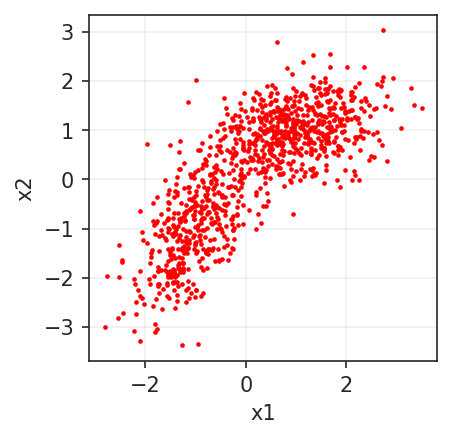

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
df = pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, color="red", linewidth=0, ax=ax)
ax.grid(alpha=0.3)

Теперь разберёмся с тем, как именно реализуется алгоритм EM.

Допустим, мы ожидаем увидеть тут два кластера. Априортное распределение количества точек в кластерах $\phi$ ($p(y)$) будет распределено биномиально (то есть есть некоторая вероятность, что точки принадлежат к одному или другому кластеру). Иногда эту вероятность имеет смысл задать явно (когда у нас действительно есть представление о том, как точки должны быть распределены между кластерами), однако в любом случае она будет оптимизироваться и далее.

Вероятность того, что точка принадлежит к кластеру ($p(x | y)$) распределена по Гауссиане с параметрами $\mu$ и $\sigma$.

Таким образом, наша система описывается следующими параметрами
$\theta := \phi, \mu_1, \sigma_1, \mu_2, \sigma_2$. Зададим их изначально случайно.

In [14]:
import numpy as np
x = np.random.normal(0, 1, size=(2, 2))
np.dot(x, x.transpose())

array([[3.11892784, 0.56759356],
       [0.56759356, 0.54034263]])

In [41]:
np.random.uniform(0, 1)

0.6021680481347699

In [15]:
import numpy as np

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

params = {
    "phi" : np.random.uniform(0, 1), # Доля точек, принадлежащих к кластеру 1

    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2

    "sigma1": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd() # У 2d Гауссианы таким образом задаётся дисперсия
}

for param in params:
  print(f"{param}:")
  print(params[param], "\n")

phi:
0.12667567679511538 

mu1:
[-1.21036502 -1.33963645] 

mu2:
[-0.48763572 -1.32869809] 

sigma1:
[[1.08973018 2.06228913]
 [2.06228913 5.24229038]] 

sigma2:
[[ 1.81541104 -1.19285886]
 [-1.19285886  3.40991039]] 



Теперь отрисуем эти распределения (пока без точек):

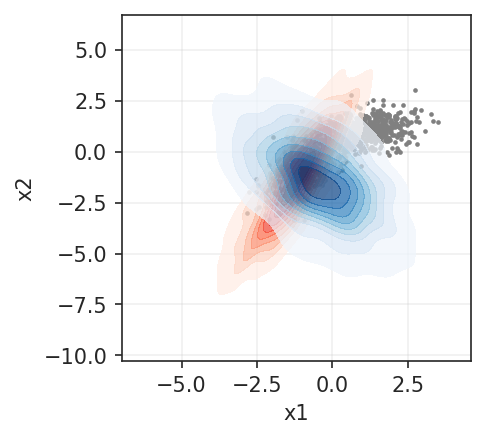

In [47]:
import scipy.stats as stats

hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, color="grey")
sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=ax, cmap="Reds", fill=True, alpha=0.7)
sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=ax, cmap="Blues", fill=True, alpha=0.7)
ax.grid(alpha=0.3)

Итак, мы получили изначальные параметры, которые мы будем оптимизировать. Как происходит оптимизация этих параметров в EM-алгоритме? В целом логика примерно та же, что и в K-Means (для тех, кто знаком, если не знакомы &mdash; мы будем разбирать этот алгоритм в ходе курса позднее).

На E-шаге мы будем для каждой точки считать вероятности принадлежности каждой из точек к тому или иному кластеру.

$$b_i = P(b | x_i) = \frac{P(x_i|b)P(b)}{P(x_i|a)P(a) + P(x_i|b)P(b)} = \frac{(\mathrm{Likelihood\;of\;x_i\;from\;b} )*(\mathrm{Prior\;probability\;of\;b})}{\mathrm{Total\;probability\;of\;x_i}} = \frac{A * B}{C} = \frac{D}{C}$$

В логарифмической форме это будет выглядеть как $$\log{b_i} = \log{P(b_i|x)} = \log{P(x_i|b)} + \log{P(b)} - \log{(P(x_i|a)P(a) + P(x_i|b)P(b))} = \mathrm{LogLikelihood} + \mathrm{Prior} - \mathrm{Total\;probability} = \log{A} + \log{B} - \log{C}$$

<b>Подсказка для понимания</b>: представьте, что $P(a) = P(b) = 0.5$. Выражение упростится до $$b_i = P(b|x_i) = \frac{P(x_i|b)}{P(x_i|b) + P(x_i|a)},$$ то есть до отношения правдоподобия того, что точка порождена распределением $b$, к сумме правдоподобий того, что точка порождена распределением $b$ и распределением $a$.

In [48]:
from scipy.special import logsumexp

X = df.values

def E_step(X, params, draw=False):
  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X),
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X)
  ])
  logPrior = B = np.log([1 - params["phi"], params["phi"]])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)

  if draw:
    hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
    hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)

    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=probabilities[:, 0], linewidth=0,
                    palette="coolwarm", ax=axes[1], s=3, alpha=1)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], linewidth=0, ax=axes[0], s=3, alpha=1, color="grey")
    sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=axes[0], cmap="Reds", fill=True, alpha=0.5)
    sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.5)
    axes[0].grid(alpha=0.3)
    axes[1].grid(alpha=0.3)
    axes[1].legend().remove()
    axes[0].set_xlim(-4, 4)
    axes[1].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    axes[1].set_ylim(-4, 4)
    plt.show()

  return RealSoftMax, probabilities

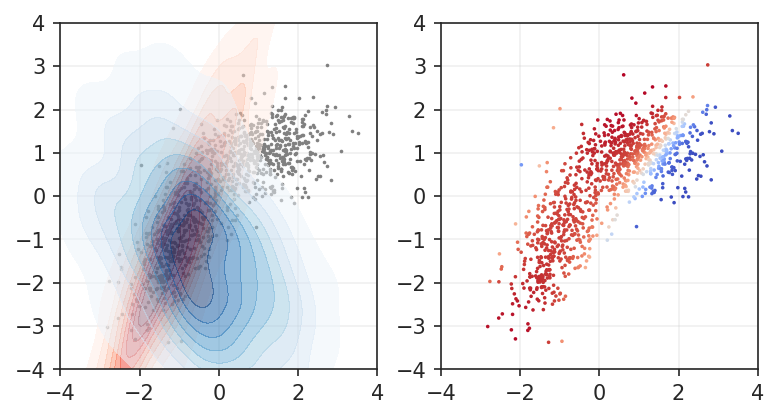

In [49]:
total_prob, probabilities = E_step(X, params, draw=True)

На следующеи шаге мы будем оптимизировать параметр $\theta$ по тому, как мы определили принадлежность точек к кластерам на E-шаге.

In [50]:
def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]

  # Вычисление новых значений
  # Пропорция = prior
  phi = prob_1.sum() / len(X)

  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)

  return {
      "phi" : phi,
      "mu1" : mu1, "mu2" : mu2,
      "sigma1": sigma1, "sigma2": sigma2
  }

Сделаем так, чтобы это выполнялось до тех пор, пока LogLikelihood не перестанет уменьшаться меньше, чем на 0.0001.

In [51]:
def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)

    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

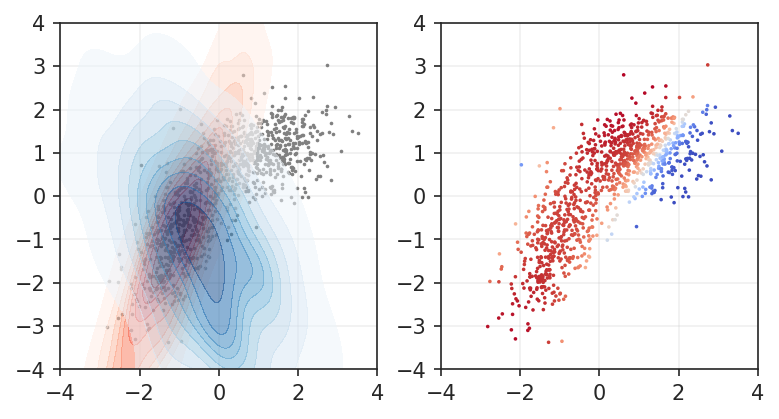

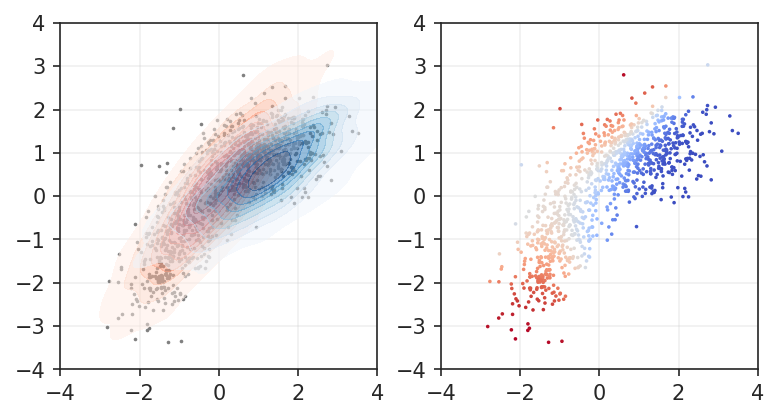

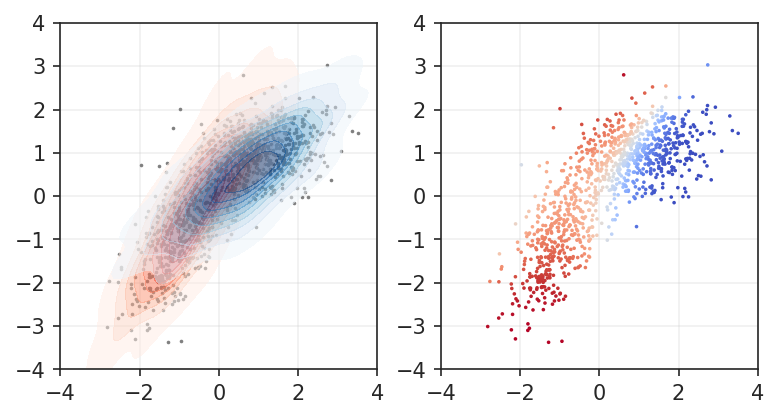

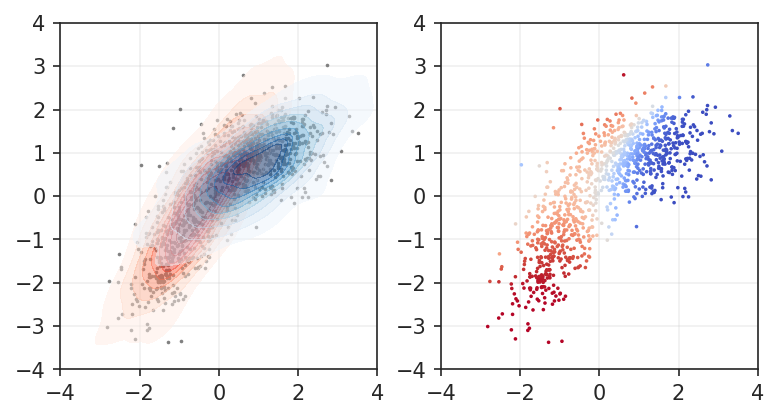

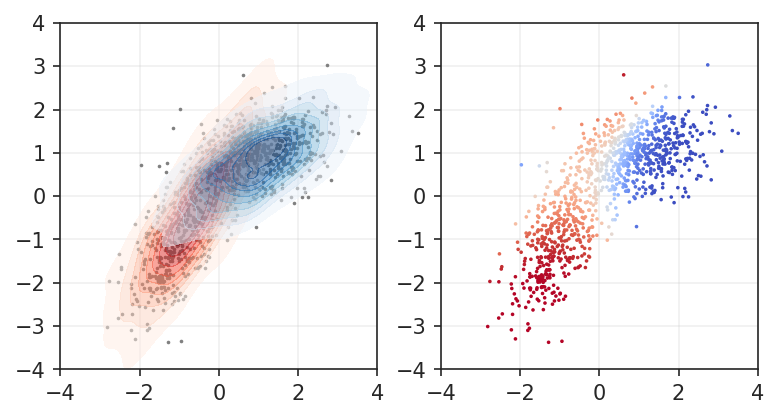

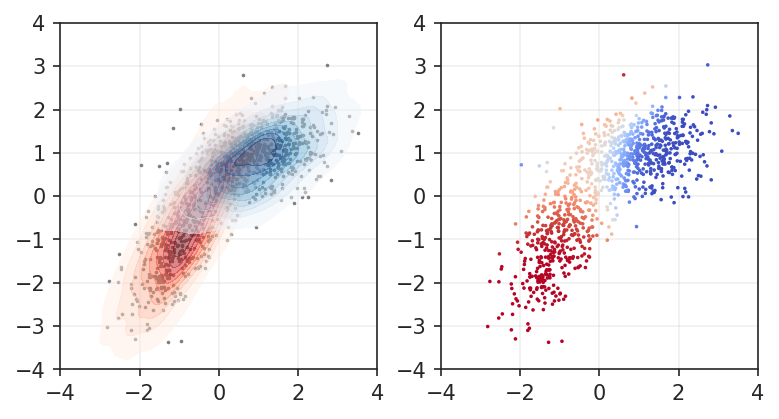

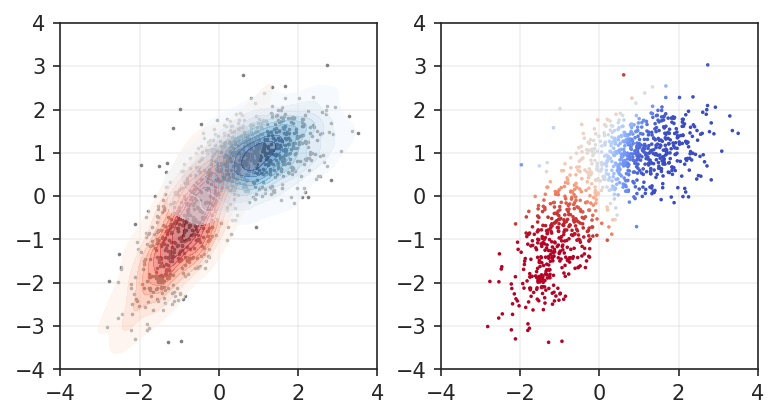

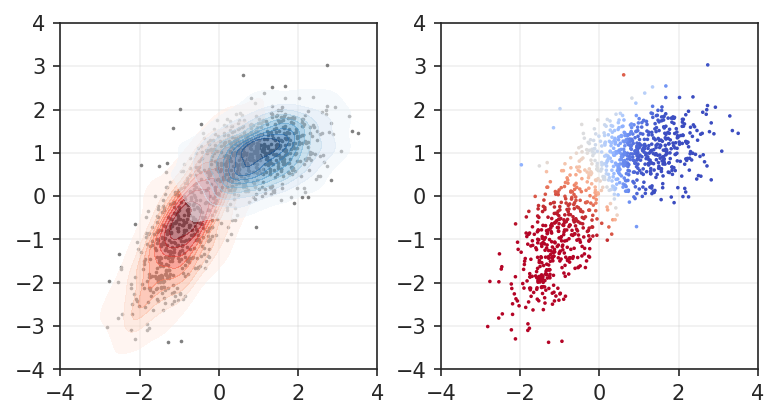

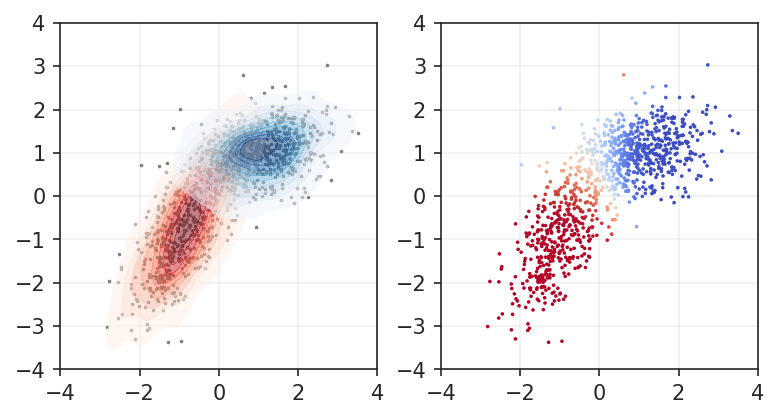

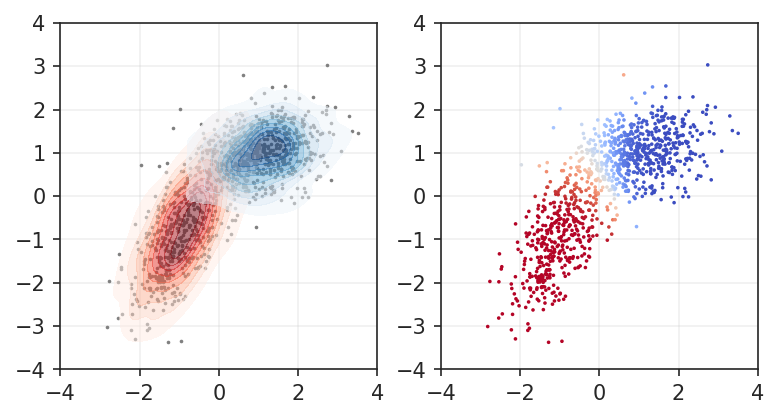

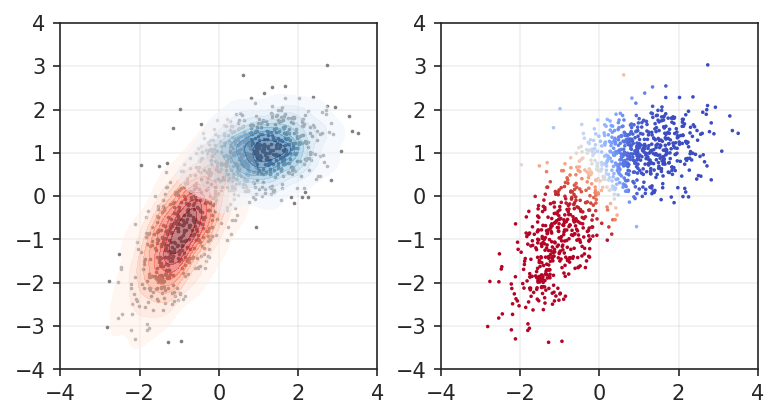

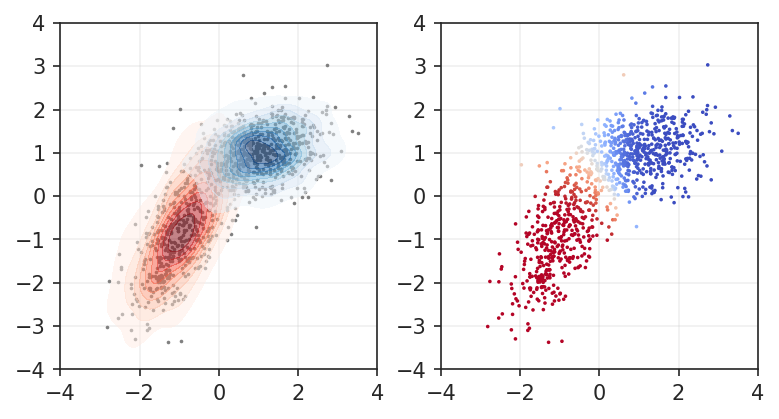

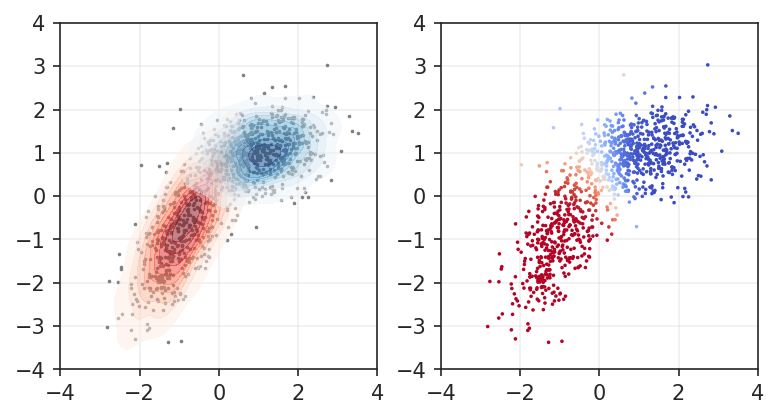

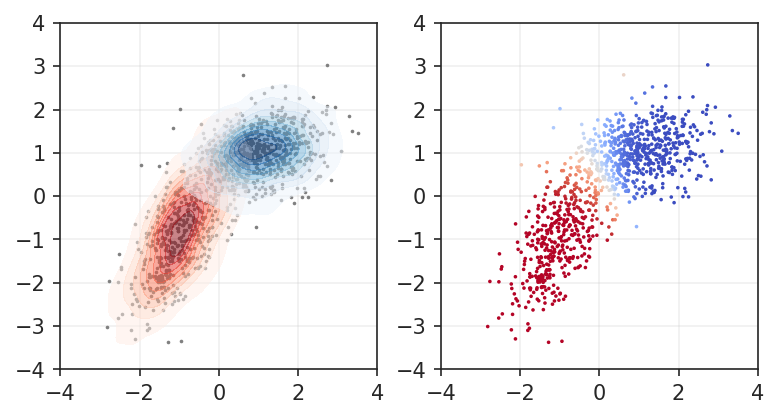

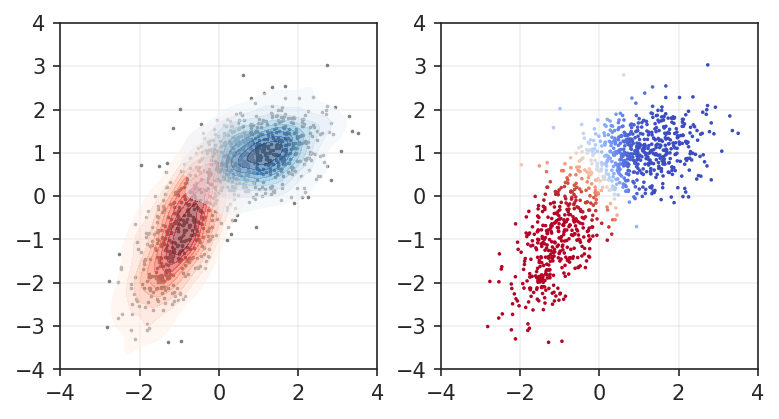

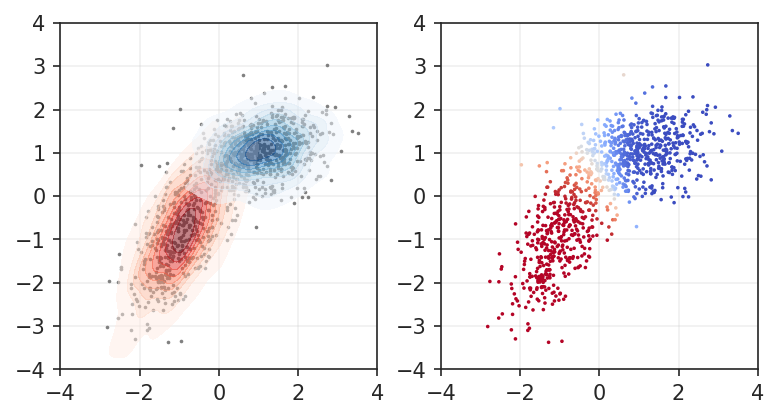

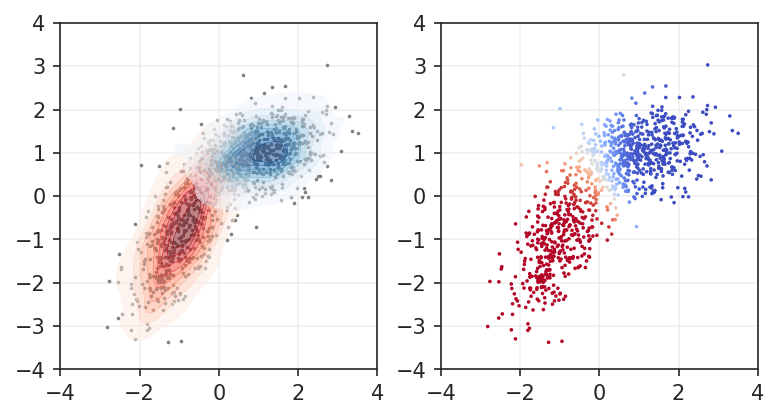

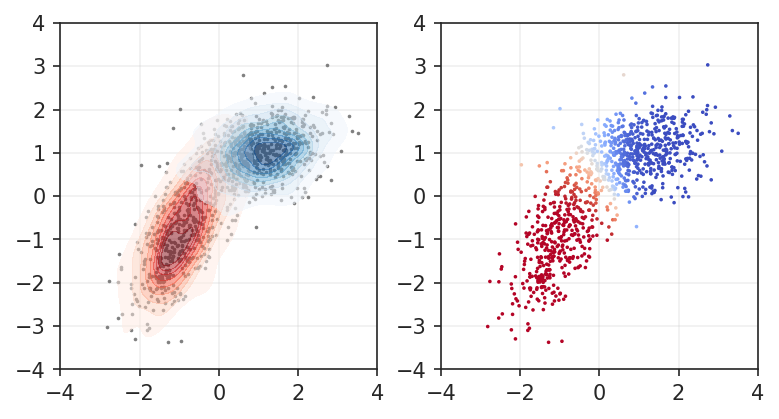

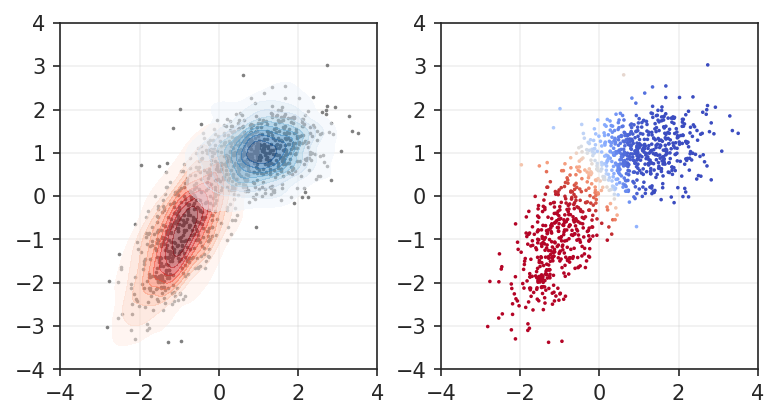

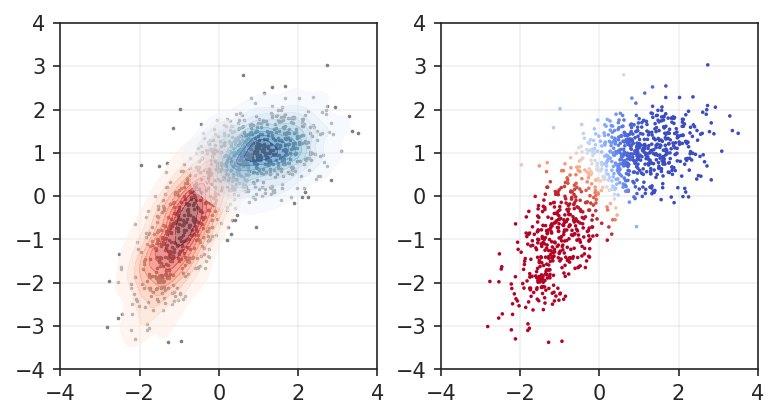

In [52]:
pred, prob, allprob = run_EM(X, params, draw=True)

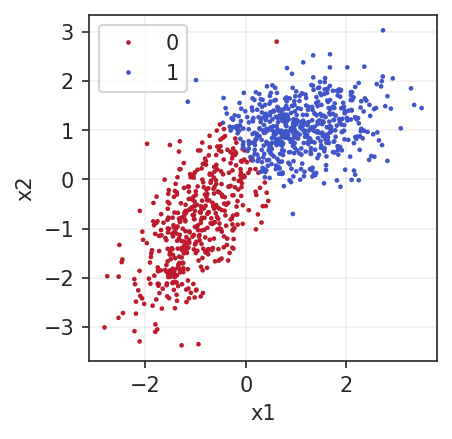

In [53]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("coolwarm", n_colors=50)[-1],
                         1: sns.color_palette("coolwarm", n_colors=50)[0]})
ax.grid(alpha=0.3)

## Kallisto

В отличие от других подходов, в kallisto отсутствует стадия выравнивания прочтений на референсный геном или транскриптом. Данный подход строит граф де Брёйна из k-меров транскриптома, после k-меры прочтений образуют пути в этом графе. Основываясь на этих путях, производится максимально правдоподобная оценка экспрессий различных транскриптов.

Подробнее про работу метода можно прочитать <a href="https://bioinfo.iric.ca/understanding-how-kallisto-works/#:~:text=The%20idea%20behind%20kallisto%20is,(not%20the%20whole%20genome)." target="_blank">здесь</a>. Первым шагом мы загрузим kallisto из git-репозитория и установим эту программу.

In [54]:
!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make

Cloning into 'kallisto'...
remote: Enumerating objects: 8747, done.
remote: Counting objects: 100% (1829/1829), done.
remote: Compressing objects: 100% (547/547), done.
remote: Total 8747 (delta 1359), reused 1602 (delta 1280), pack-reused 6918 (from 1)
Receiving objects: 100% (8747/8747), 9.42 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (5785/5785), done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
autoconf is already the newest version (2.71-2).
autoconf set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- The C compiler ide

Теперь смоделируем следующую ситуацию:

1. У нас есть линейный геном, который состоит из $N_{blocks}$ блоков длиной $l_{block}$,
2. У нас есть $M$ транскриптов, каждый из которых включает несколько из геномных блоков,
3. Для каждого из транскриптов известен его уровень экспрессии $E_i$ в количестве молекул РНК. Каждая молекула РНК генерирует $l_{t} / 1000$ прочтений.

Давайте сгенерируем такой референсный транскриптом, а также прочтения, которые будут генерироваться при таком *in silico* RNA-Seq-эксперименте. Будем считать, что все прочтения были идеальными, качество у них `I`.

In [55]:
# Generation of sequence
N_blocks = 10
l_block = 5000
transcripts = {
    "A" : [0, 1, 2],
    "B" : [1, 2, 3],
    "C" : [1, 4],
    "D" : [4, 5, 6],
    "E" : [5],
    "F" : [8, 9]
}

def generate_random_sequence(l):
  from random import choice
  return "".join([choice(["A", "T", "G", "C"]) for i in range(l)])

genome_blocks = dict(zip(range(10), [generate_random_sequence(l_block) for i in range(10)]))

# Generation of reference transcriptome
transcript_sequences = {}
with open("transcriptome.fasta", "w") as f:
  for transcript in transcripts:
    transcript_sequences[transcript] = "".join([genome_blocks[i] for i in transcripts[transcript]])
    f.write(f">{transcript}\n{transcript_sequences[transcript]}\n")

In [58]:
genome_blocks

{0: 'GCTCAAACGCCGACACTGTGAGCGACTAGCTTGGGCTCTTTACGCTCCCATTACCGAGAAGAGCGGTTATTTTAGGAGCTCAGTTAACTACAAACATATCCCTGATCCGAAGAAGGGTCCAACTAGGTTGGCACCTATAGTCCTTGTGCTCCGACAGCGCGTGAGCAGGAACCGTTCGTTAGGCAGCACTTGCCATACTAGCAGTTGCCATACATGATCACGCCCGCAGTAACAGCATCTATCGACTTATCTGGGCTACAGCGCCATTAGGCGGAGTCGATCGGTGTGGGGAGGCTTTAAGTTAACCTGGTACGGGCACTATCCCCTGAATAATATCTTAACTAGCAAGATCATCCGTTAGATATGTTATCGTTAAACATAATAGATAAACCTCTTGGTTGCTTGCGCTGACCTGCCACTTTTTGACTCCACGCGACAAATTATTGACACGTGATTAAACCTTAGGTAATCAACCACCTGCGGCGCGTACTTATCTCTGTTAAGGCTTGTTCGACAGGTTACTACTTCGTAGGGAGAGCCATATCTAGGGACGGGCTGGAACATGTAGTCTCCTGATTCCTAAGACGCGTTAACAAACGTCCACCTAAGTAAGGAGGAATGACCTGATAACCTTGCGTTCGCAAATGTCTGCTCTCGACATCGAACAACTTATCTTCAACGGGCCAGCACAGATATGAACCAGCGCAAGCATGTTTATTAGTCGAGACTGATGATCATCAACTCCGCACAGTAGTTCTTCTGACCGATGTTCGACCGTGTTCCCGGACGTGGATGGGGAGCTTCCCCCACACCTTCTTTATCGGCAGTACGACTATTTTTGGTTTAAGAATGTAATGAGTCTACGGGTAGAAAAGCCAATGCGGTTTACATTAAATCTGGCCAACAAGTCGCAGGTCGTTTCGCCATGACGGGTCAGCGATTTTCCGCTGGGGCATGGTGTAATTCGTTAGGCATTTGCTTAACGGCGACTACCG

In [59]:
# Generation of reads
l_read = 100
E = {
    "A" : 100,
    "B" : 100,
    "C" : 30,
    "D" : 0,
    "E" : 20,
    "F" : 10
}

from random import randint
with open("reads.fastq", "w") as f:
  counter = 0
  for transcript in E:
    for i in range(E[transcript]):
      for j in range(len(transcript_sequences[transcript]) // 1000):
        read_start = randint(0, len(transcript_sequences[transcript]) - (l_read + 1))
        quality = "I" * l_read
        f.write(f"@read_{counter}\n{transcript_sequences[transcript][read_start:(read_start + l_read)]}\n+\n{quality}\n")
        counter += 1

Теперь создадим индекс с нашим референсом при помощи `kallisto index`:

In [60]:
!./kallisto/build/src/kallisto index -i transcriptome.idx transcriptome.fasta


[build] loading fasta file transcriptome.fasta
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 45258
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 11486
CompactedDBG::filter(): Processed 69820 k-mers in 6 reads
CompactedDBG::filter(): Found 44893 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 311
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 20 unitigs
CompactedDBG::construct(): After split (1/1): 20 unitigs
CompactedDBG::

А теперь подсчитаем наши экспрессии при помощи `kallisto quant`:

In [61]:
l = l_read
# используем параметры для одноконцевых прочтений (как в этом игрушечном примере)
!./kallisto/build/src/kallisto quant -i transcriptome.idx -o results --single -l $l -s 1 reads.fastq
# на деле прочтения будут двуконцевыми, так что параметров для запуска нужно будет использовать меньше:
#!./kallisto/build/src/kallisto quant -i transcriptome.idx -o results reads.fastq


[quant] fragment length distribution is truncated gaussian with mean = 100, sd = 1
[index] k-mer length: 31
[index] number of targets: 6
[index] number of k-mers: 44,940
[quant] running in single-end mode
[quant] will process file 1: reads.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 3,500 reads, 3,500 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 52 rounds



Теперь сравним, какое распределение экспрессий мы подали в самом начале, и что мы получили на выходе из kallisto. Нам нужен будет файл `abundance.tsv`, а конкретно столбец `TPM` (что это такое мы разберём на следующей лекции):

In [62]:
results = pd.read_csv("results/abundance.tsv", sep="\t", index_col=0)
E_truth = dict(zip(E.keys(), [[i] for i in E.values()]))
df = pd.DataFrame(E_truth, index=["expression_truth"]).T
df["expression_pred"] = results["tpm"]
df.expression_truth = df.expression_truth / df.expression_truth.sum()
df.expression_pred = df.expression_pred / df.expression_pred.sum()
df

,expression_truth,expression_pred
A,0.384615,3.783881e-01
B,0.384615,3.907441e-01
C,0.115385,1.144530e-01
D,0.000000,5.755242e-12
E,0.076923,7.786932e-02
F,0.038462,3.854541e-02
